In [0]:
#Cargo librerias a utilizar

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [29]:
#Clono el git que tiene las fotos necesarias para realizar el entrenamiento

!rm -rf 'CursoIbmControlDePersonal'
! git clone https://github.com/leonardoacosta91/CursoIbmControlDePersonal.git

Cloning into 'CursoIbmControlDePersonal'...
remote: Enumerating objects: 893, done.
remote: Counting objects: 100% (893/893), done.
remote: Compressing objects: 100% (872/872), done.
remote: Total 1780 (delta 20), reused 885 (delta 17), pack-reused 887
Receiving objects: 100% (1780/1780), 230.83 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Checking out files: 100% (1126/1126), done.


In [30]:
#preprocesamiento de imagenes
train_path_dir='./CursoIbmControlDePersonal/Codigo modelo/Dataset Equipo/Train/'
test_path_dir='./CursoIbmControlDePersonal/Codigo modelo/Dataset Equipo/Test/'
ruta_proyecto = "/content/gdrive/My Drive/Colab Notebooks/Senpai Academy - IBM Machine Learning/"

entrenamiento_datagen = ImageDataGenerator(
		rescale=1./255,
		shear_range=0.3,
		zoom_range=0.3,
		horizontal_flip=True
)

validacion_datagen = ImageDataGenerator(
		rescale=1./255
)

imagen_entrenamiento = entrenamiento_datagen.flow_from_directory(
		train_path_dir,
		target_size=(224,224),
		batch_size=(32),
		class_mode='categorical',
		shuffle=True,
    seed=42
)

imagen_validacion = validacion_datagen.flow_from_directory(
		test_path_dir,
		target_size=(224,224),
		batch_size=(32),
		class_mode='categorical',
		shuffle=True,
    seed=42
)



Found 353 images belonging to 3 classes.
Found 92 images belonging to 3 classes.


In [35]:
#comiezon a generar el modelo

from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',input_shape=(224, 224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 50176)            

In [0]:
#se realizaron pruebas y el que mejor rendimiento tuvo fue el ADAM

#model.compile(loss='categorical_crossentropy', optimizer = "rmsprop", metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(), metrics=['accuracy'])

In [38]:
from keras.callbacks import ModelCheckpoint   
from keras.callbacks import EarlyStopping

#Defino callback con paciencia 2 y guardo el mejor modelo
checkpointer = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='./model.weights.best.hdf5', verbose=1, save_best_only=True)]

#entreno el modelo
history = model.fit_generator(imagen_entrenamiento,steps_per_epoch=353, validation_data=imagen_validacion,callbacks=checkpointer,validation_steps=92,epochs=15)


Epoch 1/15
353/353 [==============================] - 183s 518ms/step - loss: 0.0727 - acc: 0.9766 - val_loss: 0.0379 - val_acc: 0.9784

Epoch 00001: val_loss improved from inf to 0.03795, saving model to ./model.weights.best.hdf5
Epoch 2/15
353/353 [==============================] - 176s 499ms/step - loss: 0.0065 - acc: 0.9983 - val_loss: 9.7020e-04 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.03795 to 0.00097, saving model to ./model.weights.best.hdf5
Epoch 3/15
353/353 [==============================] - 179s 507ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 8.2973e-05 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00097 to 0.00008, saving model to ./model.weights.best.hdf5
Epoch 4/15
353/353 [==============================] - 175s 494ms/step - loss: 1.8125e-04 - acc: 0.9999 - val_loss: 1.9610e-05 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00008 to 0.00002, saving model to ./model.weights.best.hdf5
Epoch 5/15
353/353 [============================

In [39]:
#cargo el mejor modelo obtenido y verifico su rendimiento
from keras.models import load_model

mejor_modelo = load_model('./model.weights.best.hdf5')
train_loss, train_acc = mejor_modelo.evaluate(imagen_entrenamiento)
test_loss, test_acc = mejor_modelo.evaluate(imagen_validacion)

print('\nTrain accuracy:', train_acc)
print('\nTest accuracy:', test_acc)

3/3 [==============================] - 0s 158ms/step

Train accuracy: 1.0

Test accuracy: 1.0


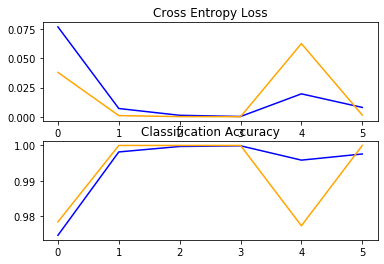

In [40]:
#grafico el historial

import matplotlib.pyplot as plt
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')

plt.show()

In [41]:
#Levanto usuario de google drive para guardar el modelo
from google.colab import drive

try:
  drive.mount('/content/gdrive')
except Exception as e:
  print(str(e))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Guardo el modelo y sus pesos
mejor_modelo.save(ruta_proyecto +'/modelo_accuracy_'+str(test_acc)[2:] +'.h5')
mejor_modelo.save_weights(ruta_proyecto +'/pesos_accurracy_'+str(test_acc)[2:] +'.h5')

# Otras pruebas realizadas

Utilizacion de extraccion facial para posibles mejoras de resultados

In [0]:
!pip install mtcnn
import mtcnn

In [0]:
# example of face detection with mtcnn
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import glob
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
  # load image from file
  pixels = pyplot.imread(filename)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  # extract the bounding box from the first face
  x1, y1, width, height = results[0]['box']
  x2, y2 = x1 + width, y1 + height
  # extract the face
  face = pixels[y1:y2, x1:x2]
  # resize pixels to the model size
  image = Image.fromarray(face)
  image = image.resize(required_size)
  #Image.save(image,"JPEG")
  face_array = asarray(image)
  return face_array
 
pixels = extract_face('./CursoIbmControlDePersonal/Dataset Famosos Senpai/Train/Adele/32.jpg')

# for file in glob.glob("./CursoIbmControlDePersonal/Dataset Famosos Senpai/Train/*/*.jpg"):
#   #print(file)
#   try:
#     # load the photo and extract the face
#     pixels = extract_face(file)

#     #guardar imagenes
#     pyplot.imsave("/content/gdrive/My Drive/"+ file[2:], pixels)
#     #pyplot.imsave('./CursoIbmControlDePersonal/name.png', pixels)
#   except Exception as e:
#     print("fallo el archivo " + file)

# plot the extracted face
pyplot.imshow(pixels)
# show the plot
pyplot.show()

Otra opcion a tener en cuenta es utilizar transfer learning y copiar el modelo Resnet50

In [0]:
#prueba transfer learning
from keras import applications
from keras.models import Sequential
from keras.layers import Dense

#obtengo arquitectura de Resnet con sus pesos correspondientes
resnete = applications.resnet.ResNet50(weights = 'imagenet',pooling="avg",include_top = False)

#congelo las capas para que no se entrenen
for capa in resnete.layers:
  capa.trainable=False

#genero nuevo modelo con las capas y sumada la capa de resultados
model = Sequential()
model.add(resnete)
model.add(Dense(3,activation='softmax'))  